In [1]:
# Microsoft dataset
# https://finance.yahoo.com/quote/MSFT/history
# Time Period: Mar 14, 1986 - Oct 31, 2022 Daily Prices

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import torch
import torch.nn as nn
import time, math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

         Date      Open      High       Low     Close  Adj Close     Volume
0  1986-03-14  0.097222  0.102431  0.097222  0.100694   0.063158  308160000
1  1986-03-17  0.100694  0.103299  0.100694  0.102431   0.064247  133171200
2  1986-03-18  0.102431  0.103299  0.098958  0.099826   0.062613   67766400
3  1986-03-19  0.099826  0.100694  0.097222  0.098090   0.061524   47894400
4  1986-03-20  0.098090  0.098090  0.094618  0.095486   0.059891   58435200
         Date     Close
0  1986-03-14  0.100694
1  1986-03-17  0.102431
2  1986-03-18  0.099826
3  1986-03-19  0.098090
4  1986-03-20  0.095486


c:\Users\lizhe.DESKTOP-KN754PS\anaconda3\envs\ptenv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


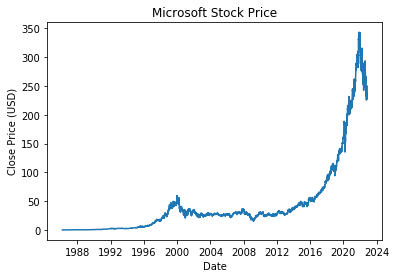

In [3]:
def to_datetime(date):
    d = date.split('-')
    yy,mm,dd = int(d[0]), int(d[1]), int(d[2])
    return dt.datetime(yy,mm,dd)

def read_data(data, company):
    d = pd.read_csv(data)
    df = d[['Date', 'Close']]
    print(d.head())
    print(df.head())
    df['Date'] = df['Date'].apply(to_datetime)
    return df

def plot_data(df, company):
    # plot scaled data
    plt.plot(df['Date'], df['Close'])
    plt.title("{} Stock Price".format(company))
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.show()

def preprocessing(data, window_size, test_split):
    data = df.filter(['Close'])
    dataset = data.values
    
    # scale data
    scaler = MinMaxScaler(feature_range=(0,1))
    data['Close'] = scaler.fit_transform(dataset)
    data_raw = data.to_numpy()

    d = []
    for index in range(len(data_raw) - window_size): 
        d.append(data_raw[index: index + window_size])
    d = np.array(d)

    train_size = len(d)-int(np.round(test_split*len(d))) + 1
    return [d[:train_size,:-1,:], d[:train_size,-1,:], d[train_size:,:-1], d[train_size:,-1,:]], scaler


df = read_data('MSFT.csv', 'Microsoft')
plot_data(df, 'Microsoft')


In [4]:
class LSTM(nn.Module):
    def __init__(self, input, hidden, num_layers, output):
        super(LSTM, self).__init__()
        self.hidden = hidden
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input, hidden, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden, output)
        
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [5]:
def training(x_train, y_train, scaler, model, criterion, optimiser, epochs=100):
    # train model
    losses = np.zeros(epochs)
    for t in range(epochs):
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        print("Epoch ", t, "MSE: ", loss.item())
        losses[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    # calculate MSE & RMSE
    y_pred = scaler.inverse_transform(y_pred.detach().numpy())
    y_train = scaler.inverse_transform(y_train.detach().numpy())
    MSE = np.round(mean_squared_error(y_train[:,0], y_pred[:,0]),3)
    RMSE = np.round(math.sqrt(mean_squared_error(y_train[:,0], y_pred[:,0])),3)
    print('Train Score: {} MSE, {} RMSE'.format(MSE, RMSE))

    predict = pd.DataFrame(y_pred)
    target = pd.DataFrame(y_train)

    return predict, target, losses

def plot_traning(predict, target, losses):
    # plot training process
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss')
    
    fig.set_figheight(6)
    fig.set_figwidth(15)

    plt.subplot(1, 2, 2)
    plt.plot(target.index, target[0], label="Actual Price")
    plt.plot(predict.index, predict[0], label="Prediction Price of Training Data")
    plt.title('Stock Price')
    plt.xlabel("Days")
    plt.ylabel("$ (USD)")
    plt.legend()
    plt.show()

In [6]:
def predicting(x_test, y_test, model, scaler):
    # make predictions
    y_pred = model(x_test)
    y_pred = scaler.inverse_transform(y_pred.detach().numpy())
    y_test = scaler.inverse_transform(y_test.detach().numpy())

    # calculate MSE & RMSE
    MSE = np.round(mean_squared_error(y_test[:,0], y_pred[:,0]),3)
    RMSE = np.round(math.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0])),3)
    print('Train Score: {} MSE, {} RMSE'.format(MSE, RMSE))


### (1) window_size = 10

In [7]:
window_size = 10

[x_train, y_train, x_test, y_test], scaler = preprocessing(df, window_size, 0.2)
# convert to torch tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

model = LSTM(input=1, hidden=32, output=1, num_layers=2)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
predict, target, losses = training(x_train, y_train, scaler, model, criterion, optimiser, epochs=100)

Epoch  0 MSE:  0.014073118567466736
Epoch  1 MSE:  0.0032785774674266577
Epoch  2 MSE:  0.005051652900874615
Epoch  3 MSE:  0.002143748104572296
Epoch  4 MSE:  0.0019374446710571647
Epoch  5 MSE:  0.002774191554635763
Epoch  6 MSE:  0.002983979880809784
Epoch  7 MSE:  0.002559240907430649
Epoch  8 MSE:  0.002021355088800192
Epoch  9 MSE:  0.0017539814580231905
Epoch  10 MSE:  0.001838314114138484
Epoch  11 MSE:  0.0020893823821097612
Epoch  12 MSE:  0.0022420885507017374
Epoch  13 MSE:  0.002178394701331854
Epoch  14 MSE:  0.0019807987846434116
Epoch  15 MSE:  0.0018021174473688006
Epoch  16 MSE:  0.001734066056087613
Epoch  17 MSE:  0.001773454830981791
Epoch  18 MSE:  0.0018590291729196906
Epoch  19 MSE:  0.001923572737723589
Epoch  20 MSE:  0.001928954035975039
Epoch  21 MSE:  0.0018761580577120185
Epoch  22 MSE:  0.0017955271760001779
Epoch  23 MSE:  0.0017267247894778848
Epoch  24 MSE:  0.0016977771883830428
Epoch  25 MSE:  0.001711496850475669
Epoch  26 MSE:  0.001745807123370468

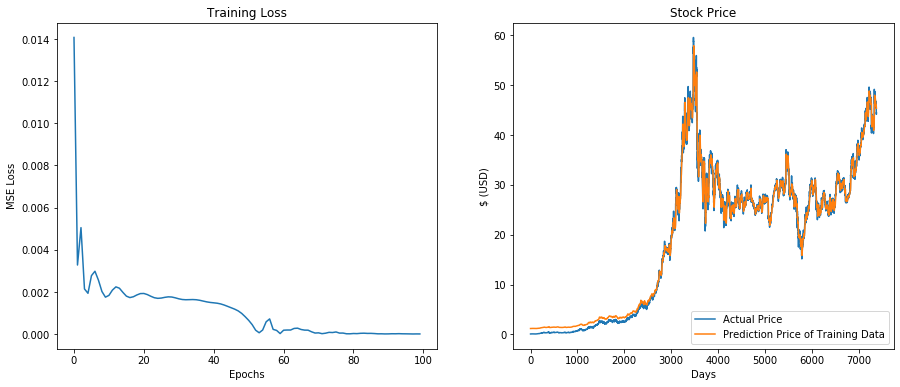

In [8]:
plot_traning(predict, target, losses)

In [9]:
predicting(x_test, y_test, model, scaler)

Train Score: 5687.11376953125 MSE, 75.413 RMSE


### (2) window_size=20

In [14]:
window_size = 20

[x_train, y_train, x_test, y_test], scaler = preprocessing(df, window_size, 0.2)
# convert to torch tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

model = LSTM(input=1, hidden=32, output=1, num_layers=2)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
predict2, target2, losses2 = training(x_train, y_train, scaler, model, criterion, optimiser, epochs=100)

Epoch  0 MSE:  0.025799868628382683
Epoch  1 MSE:  0.001751059084199369
Epoch  2 MSE:  0.012212701141834259
Epoch  3 MSE:  0.00587767967954278
Epoch  4 MSE:  0.0020150502678006887
Epoch  5 MSE:  0.002186692086979747
Epoch  6 MSE:  0.003467788454145193
Epoch  7 MSE:  0.004066815134137869
Epoch  8 MSE:  0.0037896125577390194
Epoch  9 MSE:  0.003073438536375761
Epoch  10 MSE:  0.0023583797737956047
Epoch  11 MSE:  0.0019043840002268553
Epoch  12 MSE:  0.0017849175492301583
Epoch  13 MSE:  0.0019299167906865478
Epoch  14 MSE:  0.002186552854254842
Epoch  15 MSE:  0.0023942855186760426
Epoch  16 MSE:  0.0024544449988752604
Epoch  17 MSE:  0.0023597353138029575
Epoch  18 MSE:  0.002172380918636918
Epoch  19 MSE:  0.001976219704374671
Epoch  20 MSE:  0.0018358862726017833
Epoch  21 MSE:  0.0017786540556699038
Epoch  22 MSE:  0.0017966142622753978
Epoch  23 MSE:  0.0018598403548821807
Epoch  24 MSE:  0.0019319754792377353
Epoch  25 MSE:  0.0019829031080007553
Epoch  26 MSE:  0.0019961013458669

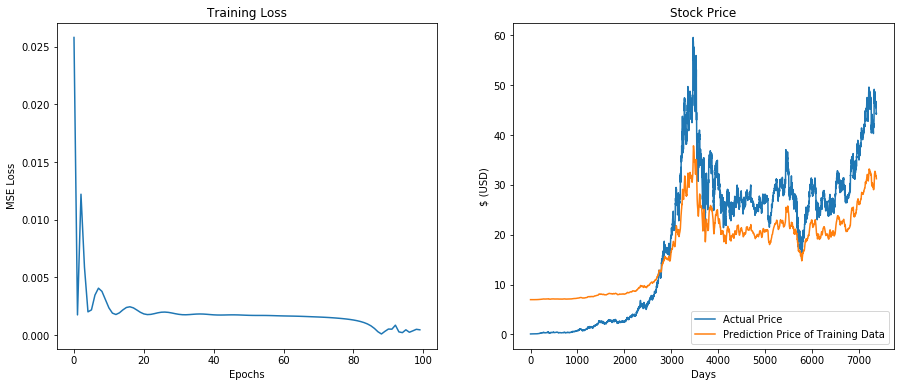

In [15]:
plot_traning(predict2, target2, losses2)

In [16]:
predicting(x_test, y_test, model, scaler)

Train Score: 13321.8056640625 MSE, 115.42 RMSE
